# Comparing f_up verses a t-statistic

In [1]:
import NotebookImport
from Imports import *

importing IPython notebook from Imports

In [4]:
matched_rna = pd.read_hdf('/data_ssd/RNASeq_2015_04_02.h5', 'matched_tn')
matched_rna = matched_rna.ix[ti((matched_rna == -3).sum(1) != 
                                len(matched_rna.columns))]

In [169]:
n = len(matched_rna.columns.levels[0])
dx_rna = binomial_test_screen(matched_rna, fc=1.)
dx_rna = dx_rna[dx_rna.num_dx > (n / 2.)]

In [6]:
ttest_all = matched_rna.apply(ttest_rel, 1)

In [183]:
from Stats.Scipy import _split_on_index
def wilcoxon_pandas(a, b=None):
    """
    Wrapper to do a one way t-test on pandas matched samples
    ------------------------------------------------
    a,b: matched measurements

    OR

    a: Series of matched measurements with assignment on second level
       of multi-index.
    """
    if isinstance(b, pd.Series):
        a, b = _match_series(a, b)
    elif b is None and isinstance(a.index, pd.MultiIndex):
        a, b = _split_on_index(a, matched=True)
    z, p = stats.wilcoxon(a, b, zero_method='zsplit')
    return pd.Series({'T': z, 'p': p})

In [184]:
wilcoxon_all = matched_rna.apply(wilcoxon_pandas, 1)
wilcox_stat = wilcoxon_all['T'] * np.sign(frac[669] - .5)

In [185]:
rank_sum = 1.*sum(range(669+1))
ts = ((rank_sum - wilcoxon_all['T']) / rank_sum) - (wilcoxon_all['T'] / rank_sum)
ts = (ts * np.sign(frac[669] - .5)).dropna()

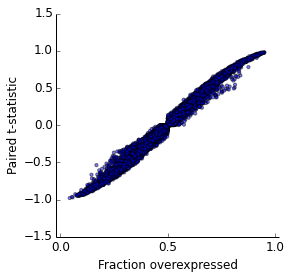

In [186]:
fig, ax = subplots(figsize=(4,4))
series_scatter(dx_rna.frac, ts, ax=ax, ann=None, s=10, alpha=.5,
               rasterized=True)
ax.set_xbound(-.05,1.05)
ax.set_xlabel('Fraction overexpressed')
ax.set_ylabel('Paired t-statistic')
ax.set_xticks([0,.5,1.])
ax.set_xbound(-.02,1.02)
#ax.set_ybound(-45,45)
prettify_ax(ax)

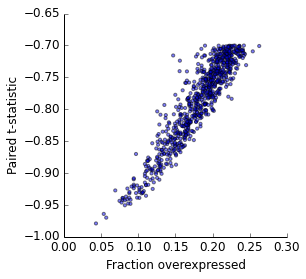

In [197]:
fig, ax = subplots(figsize=(4,4))
series_scatter(dx_rna.frac, ts[ts < -.7], ax=ax, ann=None, s=10, alpha=.5,
               rasterized=True)
ax.set_xlabel('Fraction overexpressed')
ax.set_ylabel('Paired t-statistic')
prettify_ax(ax)

In [189]:
pearson_pandas(dx_rna.frac, ts)['rho']

0.99369947994805774

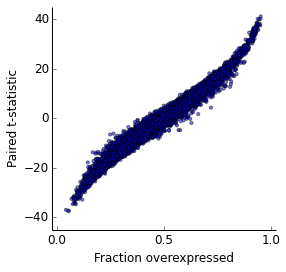

In [21]:
fig, ax = subplots(figsize=(4,4))
series_scatter(dx_rna.frac, ttest_all.t, ax=ax, ann=None, s=10, alpha=.5,
               rasterized=True)
ax.set_xbound(-.05,1.05)
ax.set_xlabel('Fraction overexpressed')
ax.set_ylabel('Paired t-statistic')
ax.set_xticks([0,.5,1.])
ax.set_xbound(-.02,1.02)
ax.set_ybound(-45,45)
prettify_ax(ax)

In [27]:
all_pts = matched_rna.columns.levels[0]

In [219]:
%%time
frac = {}
tstat = {}
pcc = {}
for n in [3,4,5,6,7,8,9,10,12,15,17,20,22,25,30,40,50,75,100,
          150,200,250,300,350,400,450,500,550,600,len(all_pts)]:
    pts = np.random.choice(all_pts, size=n, replace=True)
    n = len(pts)
    dx_rna = binomial_test_screen(matched_rna[pts], fc=1.)
    dx_rna = dx_rna[dx_rna.num_dx > (n / 2.)]
    ttest_all = matched_rna[pts].apply(ttest_rel, 1)
    frac[n] = dx_rna.frac
    tstat[n] = ttest_all.t
    pcc[n] = pearson_pandas(dx_rna.frac, ttest_all.t)['rho']
pcc = pd.Series(pcc)
frac = pd.DataFrame(frac)
tstat = pd.DataFrame(tstat)

CPU times: user 19min 22s, sys: 2.31 s, total: 19min 24s
Wall time: 19min 24s


Correlation of t-statistic and fraction overexpressed

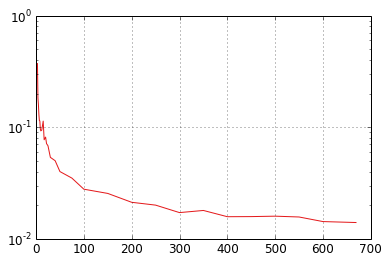

In [220]:
fig, ax = subplots()
(1 - pcc).sort_index().plot()
plt.yscale('log')

Correlation of subsampled population with full data

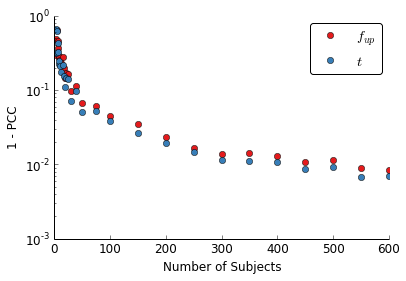

In [223]:
fig, ax = subplots()
(1 - frac.corr()[669].sort_index()[:-1]).plot(ls='', marker='o', ax=ax, label='$f_{up}$')
(1 - tstat.corr()[669].sort_index()[:-1]).plot(ls='', marker='o', ax=ax, label='$t$')
ax.set_yscale('log')
ax.set_xlabel('Number of Subjects')
ax.set_ylabel('1 - PCC')
ax.legend(numpoints=1, fancybox=True)
prettify_ax(ax)

#### Lets look at the genes that disagree between the two statistics

In [78]:
(frac[669].dropna().rank() - tstat[669].rank()).order().dropna().abs().tail(10)

TNNI1       4054.0
DNASE1      4199.0
C19orf46    4479.0
A2LD1       4504.5
ACY1        4594.5
HRG         4611.0
CNKSR1      4631.5
ESRP1       5927.0
GRHL2       6298.0
RAB25       6608.0
Name: 669, dtype: float64

In [108]:
frac.ix['RAB25'][669], tstat.ix['RAB25'][669]

(0.57571214392803594, -4.8295741811114024)

In [113]:
wilcoxon_pandas(matched_rna.ix['RAB25'])

T    110610.00
p         0.88
dtype: float64

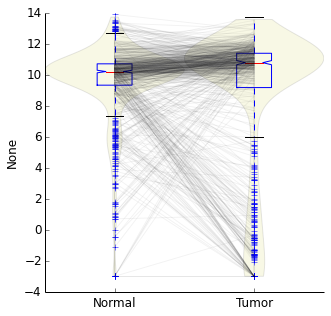

In [101]:
fig, ax = subplots(figsize=(5,5))
mm = matched_rna.ix['RAB25'].unstack()[['01','11']].dropna().stack()
violin_plot_series(mm, ax=ax, order=['11','01'], ann=None)

for i,v in mm.unstack().iterrows():
    ax.plot([0,1],[v['11'], v['01']], color='black', alpha=.05)
ax.set_xlabel('')
ax.set_xticklabels(['Normal','Tumor'])
prettify_ax(ax)